In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import metrics
import pydotplus

In [2]:
# Bring in modeling data
df = pd.read_csv('modeling_dfs/users_order_by_prev_dept.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

#join a dataframe with info on organic_produce specifically
df_org_produce = pd.read_csv('modeling_dfs/users_order_by_prev_org.csv')
df_org_produce.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.merge(df_org_produce[['order_id','organic_produce','any_organic_produce',
                              'organic_non_produce','any_organic_non_produce',
                              'organic_produce_prev','any_organic_produce_prev']],on='order_id')
display(df[['organic','organic_produce']].sample(10)) #sanity check for join because any_organic_produce should always be less

display(df.head(5))
display(len(df))

,organic,organic_produce
127221,0.0,0.0
102351,4.0,3.0
26077,2.0,0.0
44863,10.0,5.0
26658,1.0,0.0
36281,2.0,1.0
87153,8.0,1.0
106173,1.0,1.0
13327,0.0,0.0
111015,6.0,3.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,"('department', 'personal care')","('department', 'pets')","('department', 'produce')","('department', 'snacks')",organic_produce,any_organic_produce,organic_non_produce,any_organic_non_produce,organic_produce_prev,any_organic_produce_prev
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,0,0,0,3,0.0,False,3.0,True,0,False
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,0,0,4,1,1.0,True,5.0,True,3,True
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,0,0,5,0,3.0,True,2.0,True,3,True
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,0,0,4,1,0.0,False,1.0,True,3,True
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,0,0,7,0,7.0,True,2.0,True,2,True


131209

In [3]:
df['bins_prior_order_days'] = pd.cut(df['days_since_prior_order'],bins=[-0.5,4.5,8.5,15.5,22.5,30.5])
display(df['bins_prior_order_days'].head())
df[['days_since_0-4','days_since_5-8','days_since_9-15','days_since_16-22','days_since_23-30']] = \
    pd.get_dummies(df['bins_prior_order_days'])
display(df.head())

0     (8.5, 15.5]
1    (22.5, 30.5]
2      (4.5, 8.5]
3      (4.5, 8.5]
4     (8.5, 15.5]
Name: bins_prior_order_days, dtype: category
Categories (5, interval[float64]): [(-0.5, 4.5] < (4.5, 8.5] < (8.5, 15.5] < (15.5, 22.5] < (22.5, 30.5]]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,organic_non_produce,any_organic_non_produce,organic_produce_prev,any_organic_produce_prev,bins_prior_order_days,days_since_0-4,days_since_5-8,days_since_9-15,days_since_16-22,days_since_23-30
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,3.0,True,0,False,"(8.5, 15.5]",0,0,1,0,0
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,5.0,True,3,True,"(22.5, 30.5]",0,0,0,0,1
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,2.0,True,3,True,"(4.5, 8.5]",0,1,0,0,0
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,1.0,True,3,True,"(4.5, 8.5]",0,1,0,0,0
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,2.0,True,2,True,"(8.5, 15.5]",0,0,1,0,0


In [4]:
#transform order characteristics into more interpretable features based on shopping tendencies
df['morning'] = df['order_hour_of_day'].apply(lambda x: True if ((x>=4) & (x<12)) else False)
display(df[['order_hour_of_day','morning']].sample(10)) #check behaving as expected.

df['weekend'] = df['order_dow'].apply(lambda x: True if x in [0,1] else False)
display(df[['order_dow','weekend']].sample(10)) #check behaving as expected.

df['num_past_orders'] = df['order_number']-1


,order_hour_of_day,morning
72582,10,True
99797,6,True
128878,15,False
55,18,False
117946,8,True
28585,9,True
50278,9,True
113432,13,False
75429,18,False
82909,13,False


,order_dow,weekend
121981,6,False
92344,2,False
120256,2,False
8184,2,False
48866,5,False
90968,0,True
72819,4,False
83129,1,True
37599,4,False
129383,3,False


,product_id,product_name,organic,freq_rank,user_id,rec_rank
0,13176,Bag of Organic Bananas,1,2,1,1
1,21137,Organic Strawberries,1,3,1,2
2,24852,Banana,0,1,1,3
3,21903,Organic Baby Spinach,1,4,1,4
4,39275,Organic Blueberries,1,11,1,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d575710>]],
      dtype=object)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,bins_prior_order_days,days_since_0-4,days_since_5-8,days_since_9-15,days_since_16-22,days_since_23-30,morning,weekend,num_past_orders,pct_organic
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,"(8.5, 15.5]",0,0,1,0,0,True,False,10,0.55
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,"(22.5, 30.5]",0,0,0,0,1,True,True,14,0.55
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,"(4.5, 8.5]",0,1,0,0,0,True,True,4,0.55
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,"(4.5, 8.5]",0,1,0,0,0,True,False,20,0.65
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,"(8.5, 15.5]",0,0,1,0,0,False,True,3,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3048078,78702,train,9,5,13,15.0,78702.009,78702.008,1891416.0,...,"(8.5, 15.5]",0,0,1,0,0,False,False,8,0.25
49996,1260736,78703,train,5,1,11,30.0,78703.005,78703.004,1827767.0,...,"(22.5, 30.5]",0,0,0,0,1,True,True,4,0.45
49997,2700517,78704,train,4,4,17,30.0,78704.004,78704.003,1286110.0,...,"(22.5, 30.5]",0,0,0,0,1,False,False,3,0.20
49998,2160403,78705,train,39,1,2,9.0,78705.039,78705.038,1042834.0,...,"(8.5, 15.5]",0,0,1,0,0,False,True,38,0.20


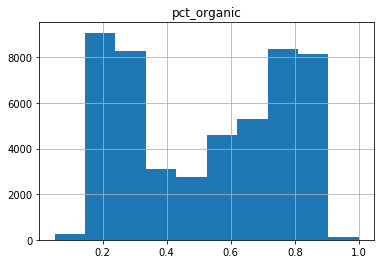

In [5]:
# import recommendation data to calculate the %organic items in the top 20 recommendations for each user

# only 50000 users because of time constraints
df_recs = pd.read_csv('top20_products_recom.csv')
df_recs.drop(['Unnamed: 0'],axis=1,inplace=True)
display(df_recs.head(5))

#group by organic column to get the sum of organic items in top 20 recs
user_pct_organic = df_recs[['user_id','organic']].groupby('user_id').sum()\
                        .rename({'organic':'pct_organic'},axis=1)/20
display(user_pct_organic.hist()) #very bimodal.
user_pct_organic.reset_index(inplace=True)

df = df.merge(user_pct_organic,on='user_id')
display(df)

In [6]:
# project departments into lower dimensional space using PCA
dept_cols = [colname for colname in df.columns.values if 'department' in colname] # include departments
dept_cols.remove("('department', 'missing')")# remove erroneous departments

num_pcs = 4 #select PCs with eigenvalues > 0.05 for relevance
pca = PCA(n_components=num_pcs)
pca.fit(df[dept_cols])
df_pca = pd.DataFrame(pca.transform(df[dept_cols]),columns=['PC{}'.format(x) for x in range(1,num_pcs+1)],
                           index=df.index)
df = df.join(df_pca)

In [7]:
# looking at what the PCs actually represent:

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
# print(pca.components_)
pca_comps = pd.DataFrame(pca.components_, columns=dept_cols)
# display(pca_comps)
pca_comps = pca_comps.transpose()
pca_comps.columns = ['PC{}'.format(x) for x in range(1,num_pcs+1)]
# display(pca_comps)

print('Principal component loadings, only abs>0.3')
for pcn,pc in enumerate(pca_comps.columns.values):
    print('PC{} ({}%)'.format(pcn+1,100*pca.explained_variance_ratio_[pcn]))
    pc_i = pd.DataFrame(pca_comps[pc])
    pc_i.loc[:,pc+'_abs'] = np.abs(pc_i[pc])
#     display(pc_i.sort_values(pc+'_abs',ascending=False))
    display(pc_i.loc[pc_i[pc+'_abs']>0.3].sort_values(pc+'_abs',ascending=False))

4
[0.45843677 0.13874772 0.08017576 0.0589898 ]
Principal component loadings, only abs>0.3
PC1 (45.84367702102733%)


,PC1,PC1_abs
"('department', 'produce')",0.950559,0.950559


PC2 (13.874772078090578%)


,PC2,PC2_abs
"('department', 'dairy eggs')",0.691317,0.691317
"('department', 'snacks')",0.466111,0.466111


PC3 (8.017576119930157%)


,PC3,PC3_abs
"('department', 'snacks')",0.674029,0.674029
"('department', 'dairy eggs')",-0.631525,0.631525
"('department', 'beverages')",0.322139,0.322139


PC4 (5.898980053069341%)


,PC4,PC4_abs
"('department', 'frozen')",0.88571,0.88571


In [8]:
# Rename PC predictors based on interpretation
df.rename({'PC1':'produce',
           'PC2':'dairyeggs_snacks',
           'PC3':'snacks_beverages_notdairyeggs',
           'PC4':'frozen_notsnacks'},axis=1,inplace=True)

In [9]:
# Validation of model using built-in methods
def print_scores(X,y,model):
    print('Precision:')
    print(metrics.precision_score(y.astype(int),model.predict(X).astype(int)))
    print('Recall:')
    print(metrics.recall_score(y.astype(int),model.predict(X).astype(int)))
    print('F1 score (0.4):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.4).astype(int)))
    print('F1 score (0.5):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.5).astype(int)))
    print('F1 score (0.6):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.6).astype(int)))
    print('Mean accuracy:')
    print(model.score(X,y))
    print('ROC AUC score:')
    print(metrics.roc_auc_score(y.astype(int),model.predict(X).astype(int)))
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y, model.predict(X)))
    
    print('ROC curve')
#     fpr, tpr, _ = metrics.roc_curve(y.astype(int),model.predict(X).astype(int))
    fpr, tpr, threshes = metrics.roc_curve(y.astype(int),model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
#     print(threshes)

In [41]:
# train the classifier on 80% of the data

y_col = 'any_organic_produce'
feature_cols = ['any_organic_produce_prev']
# feature_cols = ['any_organic_produce_prev',
#                 'days_since_5-8','days_since_9-15','days_since_16-22','days_since_23-30',
#                 'num_past_orders',
#                 'weekend','morning']
#                 'pct_organic',
#                 'produce','dairyeggs_snacks','snacks_beverages_notdairyeggs','frozen_notsnacks']
feature_cols = ['any_organic_produce_prev','pct_organic',]
print('Features:')
print(feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[y_col], test_size=0.20, random_state=22)

Features:
['any_organic_produce_prev', 'pct_organic']


# Classification tree model

[('any_organic_produce_prev', 0.7888651697484856), ('pct_organic', 0.21113483025151442)]
test data:
Precision:
0.7806841046277666
Recall:
0.7743105950653121
F1 score (0.4):
0.7933268545513443
F1 score (0.5):
0.7774842881865379
F1 score (0.6):
0.7294454090491267
Mean accuracy:
0.7557
ROC AUC score:
0.753576866160107
Confusion matrix:
[[3289 1199]
 [1244 4268]]
ROC curve


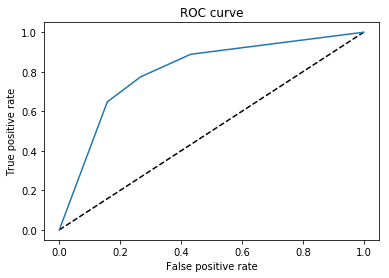

training data:
Precision:
0.7762285714285714
Recall:
0.7717129482343317
F1 score (0.4):
0.7941561712846347
F1 score (0.5):
0.7739641733898536
F1 score (0.6):
0.7257316979489412
Mean accuracy:
0.75205
ROC AUC score:
0.7498615860802708
Confusion matrix:
[[13102  4895]
 [ 5023 16980]]
ROC curve


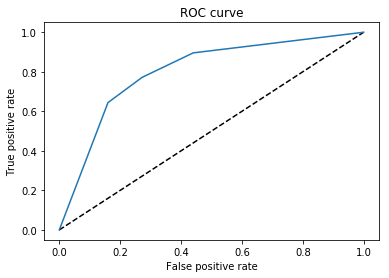

Tree:


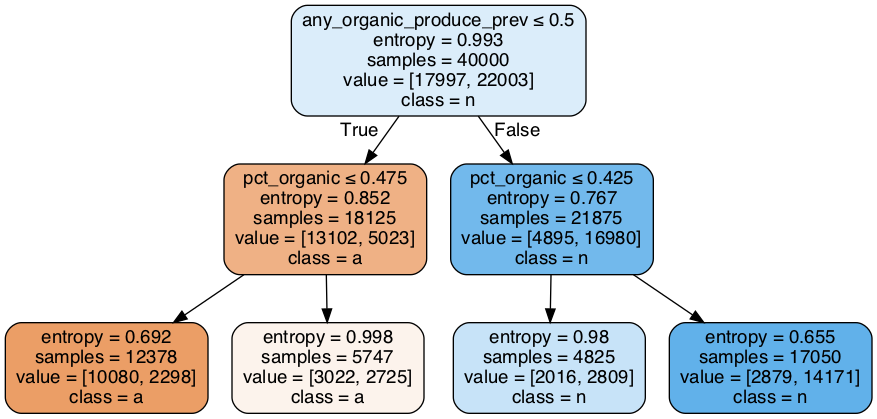

In [50]:
# regression tree
rt = tree.DecisionTreeClassifier(max_depth=2,random_state=0,criterion='entropy')
rt.fit(X_train,y_train)

print(list(zip(feature_cols,rt.feature_importances_)))

print('test data:')
print_scores(X_test,y_test,rt)

print('training data:')
print_scores(X_train,y_train,rt)

print('Tree:')
dot_data = tree.export_graphviz(rt, out_file=None, 
                         feature_names=feature_cols,  
                         class_names=y_col,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

display(Image(graph.create_png()))

# Logistic regression model

test data:
Precision:
0.7514831905075807
Recall:
0.8324205914567361
F1 score (0.4):
0.7977987159176186
F1 score (0.5):
0.7898839424909061
F1 score (0.6):
0.7542789691127286
Mean accuracy:
0.7574
ROC AUC score:
0.7494699153656967
Confusion matrix:
[[3014 1508]
 [ 918 4560]]
ROC curve


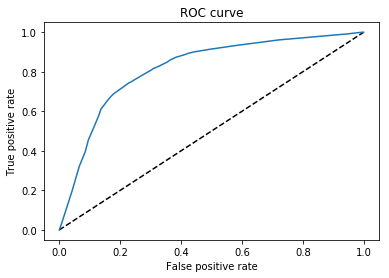

training data:
Precision:
0.7493009868421052
Recall:
0.8269274402141852
F1 score (0.4):
0.7936851751572458
F1 score (0.5):
0.7862027309791402
F1 score (0.6):
0.7476373990525049
Mean accuracy:
0.752225
ROC AUC score:
0.743753760746184
Confusion matrix:
[[11866  6097]
 [ 3814 18223]]
ROC curve


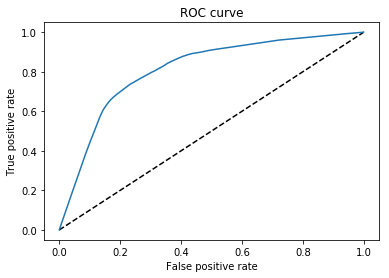

In [42]:
logisticRegr = LogisticRegression(penalty='l1',solver='liblinear')
logisticRegr.fit(X_train,y_train)

predictions = logisticRegr.predict(df[feature_cols])
df['predicted_'+y_col] = predictions
# display(df[['predicted_'+y_col,y_col]])

# print('predicted distribution:')
# display(df['predicted_'+y_col].value_counts())
# display(df['predicted_'+y_col].value_counts(normalize=True))
# print('actual distribution:')
# display(df[y_col].value_counts())
# display(df[y_col].value_counts(normalize=True))

# print('distribution of any_organic_produce_prev:')
# display(df['any_organic_produce_prev'].value_counts())
# display(df['any_organic_produce_prev'].value_counts(normalize=True))
    
print('test data:')
print_scores(X_test,y_test,logisticRegr)

print('training data:')
print_scores(X_train,y_train,logisticRegr)

#                       Predicted not-y,0   Predicted y,1
# True not-y,0
# True y,1

In [47]:
# How many new produce buyers are predicted using this model?
new_predicted_buyers = df[['predicted_'+y_col,'any_organic_produce_prev']]
new_predicted_buyers = new_predicted_buyers.loc[(new_predicted_buyers['predicted_'+y_col]==True)&
                                                (new_predicted_buyers['any_organic_produce_prev']==False)]

#3110 people for new model!
print(len(new_predicted_buyers))
print(len(df.loc[df['predicted_'+y_col]]))
print('{}% new predicted buyers'.format(100*len(new_predicted_buyers)/len(df.loc[df['predicted_'+y_col]])))
# 0 otherwise!

3110
30388
10.234303014347768% new predicted buyers


In [17]:
coefs = pd.DataFrame(list(zip(logisticRegr.coef_[0], feature_cols)),columns=['coef','feature'])
coefs['odds_ratio'] = np.exp(coefs['coef'])
coefs['delta_prob'] = coefs['odds_ratio']/(1+coefs['odds_ratio'])
display(coefs.sort_values('coef'))

,coef,feature,odds_ratio,delta_prob
0,1.761317,any_organic_produce_prev,5.820095,0.853374
1,2.656681,pct_organic,14.248913,0.934422


In [18]:
# export big model to pickle file
filename = 'saved_models/model_final.pkl'
pickle.dump(logisticRegr, open(filename, 'wb'))

#check export worked
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [50]:
# F1 score of all 1s (no targeting)
print('F1 score of all 1s, test:')
print(metrics.f1_score(y_test.astype(int),np.ones(len(y_test))))
print('F1 score of all 1s, train:')
print(metrics.f1_score(y_train.astype(int),np.ones(len(y_train))))

F1 score of all 1s, test:
0.707843390618943
F1 score of all 1s, train:
0.7104469913116367


# Working on final fitted model

In [5]:
#Work from here below to work on fitted model
filename = 'saved_models/model_final.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [19]:
logisticRegr = loaded_model
print(logisticRegr.classes_) #second column is True
df['predicted_prob'] = logisticRegr.predict_proba(df[feature_cols])[:,1]
df['user_dropdown'] = df.apply(lambda x: f"User {x['user_id']} (p={x['predicted_prob']:.2f})",axis=1)
df['user_emails'] = df.apply(lambda x: f"User {x['user_id']} <user{x['user_id']}@email.com)",axis=1)
df = df.sort_values(by='predicted_prob',ascending=False)
display(df)

[False  True]


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,num_past_orders,pct_organic,produce,dairyeggs_snacks,snacks_beverages_notdairyeggs,frozen_notsnacks,predicted_any_organic_produce,predicted_prob,user_dropdown,user_emails
8662,2324363,13558,train,33,3,10,9.0,13558.033,13558.032,1490352.0,...,32,1.00,-0.889453,0.177158,-1.172951,0.558411,True,0.910587,User 13558 (p=0.91),User 13558 <user13558@email.com)
38878,1194477,61197,train,23,0,16,8.0,61197.023,61197.022,2145877.0,...,22,1.00,-1.159432,-0.574821,-1.374999,-0.444009,True,0.910587,User 61197 (p=0.91),User 61197 <user61197@email.com)
30337,2879316,47720,train,32,3,10,7.0,47720.032,47720.031,2478882.0,...,31,1.00,1.671995,-1.489167,-0.237599,0.864392,True,0.910587,User 47720 (p=0.91),User 47720 <user47720@email.com)
6504,1914031,10195,train,9,4,11,11.0,10195.009,10195.008,1916799.0,...,8,0.95,-0.927627,3.615240,-1.582917,0.475529,True,0.899166,User 10195 (p=0.90),User 10195 <user10195@email.com)
4551,274489,7165,train,14,5,14,9.0,7165.014,7165.013,3382578.0,...,13,0.95,0.271023,-2.496128,0.060017,-0.131901,True,0.899166,User 7165 (p=0.90),User 7165 <user7165@email.com)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4606,127277,7260,train,5,1,15,30.0,7260.005,7260.004,435569.0,...,4,0.10,-3.004581,0.660072,0.983094,4.389898,False,0.138059,User 7260 (p=0.14),User 7260 <user7260@email.com)
15996,2284467,25069,train,16,1,7,30.0,25069.016,25069.015,1894915.0,...,15,0.10,1.029241,-0.731431,-0.292722,1.194201,False,0.138059,User 25069 (p=0.14),User 25069 <user25069@email.com)
39128,2371987,61618,train,40,0,15,4.0,61618.040,61618.039,2597702.0,...,39,0.10,0.144042,0.814449,0.563730,-0.211011,False,0.138059,User 61618 (p=0.14),User 61618 <user61618@email.com)
38482,2609048,60561,train,42,4,10,4.0,60561.042,60561.041,961322.0,...,41,0.05,-2.345052,3.963591,2.519836,-0.435815,False,0.122998,User 60561 (p=0.12),User 60561 <user60561@email.com)


In [20]:
# save df for displaying in front end
df.to_csv('modeling_dfs/final_users_50k.csv')

In [21]:
df['pct_organic'].describe()

count    50000.000000
mean         0.524672
std          0.258065
min          0.050000
25%          0.250000
50%          0.550000
75%          0.800000
max          1.000000
Name: pct_organic, dtype: float64

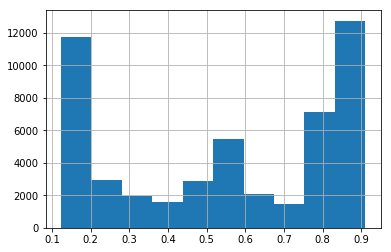

In [22]:
df['predicted_prob'].hist()